In [3]:
using LmaPredict, PyPlot
using Base.Iterators: partition
using Flux
using Flux.Optimise: update!
using Flux.Losses: logitbinarycrossentropy
using Statistics
using Random
using MLUtils


[ Info: Precompiling LmaPredict [4056ae44-f597-46f1-96e9-cdb3146ed00e]
┌ Warning: Package LmaPredict does not have ADerrors in its dependencies:
│ - If you have LmaPredict checked out for development and have
│   added ADerrors as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LmaPredict
└ Loading ADerrors into LmaPredict from project dependency, future warnings for LmaPredict are suppressed.


In [4]:
path_plot="/Users/alessandroconigli/Desktop/postdoc-mainz/projects/MLtoLMA"
path_config = "/Users/alessandroconigli/Lattice/data/HVP/LMA/A654/"


"/Users/alessandroconigli/Lattice/data/HVP/LMA/A654/"

In [5]:
## Reading data 
fname = readdir(path_config)
idx_cut = findall(x->x<=2000, parse.(Int64, fname))
fname = fname[idx_cut]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em="PA", bc=false))
end


In [436]:
## data manipulation to stadard WHCN to feed model

NCNFG = length(cnfgarr)
TVALS = length(cnfgarr[1].data["rr"]["0"]) 

TSRC_rr = collect(keys(getfield(cnfgarr[1], :data)["rr"] ))
TSRC_re = collect(keys(getfield(cnfgarr[1], :data)["re"] ))
# the sources has to be the same for both rr and ee

rr_re_images = Vector{Array{Float64}}(undef, TVALS)

for t in 1:TVALS    

    rr_re_images[t] = Array{Float64}(undef, 2, 1, length(TSRC_rr), NCNFG)
    for n in 1:NCNFG
        for (k,ts) in enumerate(TSRC_rr)
            rr_aux = getfield(cnfgarr[n], :data)["rr"][ts][t]
            re_aux = getfield(cnfgarr[n], :data)["re"][ts][t]
            
            rr_re_images[t][:,:,k, n] = [rr_aux, re_aux] 
        end
    end
end

In [437]:
## normalise data
using Statistics
min_val = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )
max_val = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )

std_val  = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )
mean_val = Array{Float64}(undef, TVALS, length(TSRC_rr), 2 )

for t in 1:TVALS
    for ts in 1:size(rr_re_images[t], 3)
        for k in 1:size(rr_re_images[t],1)
            minval = minimum(rr_re_images[t][k, 1, ts, :])
            maxval = maximum(rr_re_images[t][k, 1, ts, :])
            #rr_re_images[t][k, 1, ts, :] = normalise(rr_re_images[t][k, 1, ts, :])
            #rr_re_images[t][k, 1, ts, :] = (rr_re_images[t][k, 1, ts, :] .- minval) ./ (maxval - minval)
            mean_val[t, ts, k] = mean(rr_re_images[t][k,1,ts,:])
            std_val[t, ts, k] = std(rr_re_images[t][k,1,ts,:])
            rr_re_images[t][k, 1, ts, :] = normalise(rr_re_images[t][k,1,ts,:])
            #min_val[t, ts, k] = minval
            #max_val[t, ts, k] = maxval
        end
    end
end


In [438]:
# A vector for each TVALS
std(rr_re_images[40][1,1,2,:])
std_val


48×4×2 Array{Float64, 3}:
[:, :, 1] =
 0.00889048   0.00935023   0.00953168   0.00964622
 0.00485553   0.00500424   0.00532372   0.00527354
 0.00359844   0.00367839   0.00381547   0.00384053
 0.00274541   0.00273105   0.00275774   0.0028104
 0.00208685   0.00203667   0.00203576   0.0020769
 0.00157795   0.00154255   0.00155737   0.00153872
 0.00120042   0.00118211   0.00121216   0.00115867
 0.00092986   0.000924977  0.000943549  0.00089217
 0.0007379    0.000721477  0.000738551  0.000710804
 0.000592352  0.000564985  0.000588138  0.000577507
 0.000476361  0.000454256  0.000479075  0.000469789
 0.000386415  0.000372037  0.000393617  0.000381769
 0.000318214  0.00030741   0.000325557  0.000311453
 ⋮                                      
 0.00030798   0.00031094   0.000315212  0.000324927
 0.000379237  0.000375398  0.000382564  0.000393183
 0.000471352  0.000458285  0.000468438  0.000476842
 0.000586011  0.000568233  0.000577441  0.00058829
 0.000728075  0.000710688  0.000729365  0.000740

In [429]:
# batch dimensions
(rr_re_images[1][2,1,1,:]);

In [440]:
function discriminator()
    dscr = Chain(
        Dense(2 => 16, leakyrelu), # 2 => 16
        Dropout(0.3),
        Dense(16 => 8, leakyrelu), # 16 => 8  
        #BatchNorm(16, leakyrelu),
        #Dense(128=>64, leakyrelu),
        Dropout(0.3),
        Dense(8 => 1, sigmoid) # 8 => 1
    )
    return dscr
end

#dscr = discriminator()
#dscr(rr_re_images[1])

discriminator (generic function with 1 method)

In [441]:
function generator(latent_dim::Int)
    gen = Chain(
        Dense(latent_dim =>8),
        BatchNorm(8, relu),
        #x->reshape(x, 2, 1, 64,:),
        #Dense(64 => 128, leakyrelu), # this one is added
        Dense(8 => 16),
        BatchNorm(16, relu),
        Dense(16 => 2)
    )
    return gen
end

generator (generic function with 1 method)

In [442]:
function generate_noise(hparams)
    noise = randn(hparams.latent_dim,  hparams.batch_size)
    return noise
end

generate_noise (generic function with 1 method)

In [443]:
function generate_fake_sample(gen, hparams)
    noise = generate_noise(hparams)
    return gen(noise)
end

generate_fake_sample (generic function with 1 method)

In [444]:
# Loss functions
function discriminator_loss(real_sample, fake_sample)
    
    real_loss = logitbinarycrossentropy(real_sample, 1)
    fake_loss = logitbinarycrossentropy(fake_sample, 0)
    return real_loss + fake_loss
end

generator_loss(fake_sample) = logitbinarycrossentropy(fake_sample, 1)


generator_loss (generic function with 1 method)

In [445]:
function train_discriminator!(gen, dscr, real_sample, opt_discr, hparams)
    
    #noise = randn!(similar(real_sample, (hparams.latent_dim, hparams.batch_size)))
    #fake_sample = gen(noise)
    fake_sample = generate_fake_sample(gen, hparams) 
    
    loss, grad = Flux.withgradient(dscr) do dscr
        discriminator_loss(dscr(real_sample), dscr(fake_sample))
    end
    
    update!(opt_discr, dscr, grad[1])
    return loss
end

function train_generator!(gen, dscr, opt_gen, hparams)
    
    noise = generate_noise(hparams)
    
    loss, grad = Flux.withgradient(gen) do gen
        generator_loss(dscr(gen(noise)))
    end
    
    update!(opt_gen, gen, grad[1])
    return loss
end

train_generator! (generic function with 1 method)

In [446]:
function train!(data::Array{Float64,4}, dscr, gen, hparams::HyperParams; kws...)
    #hparams = HyperParams()

    data_batches = [data[:,:,:,k] for k in partition(1:size(data,4), hparams.batch_size)]

    # dscr = discriminator()
    # gen  = generator(hparams.latent_dim) 

    # optimizers
    opt_dscr = Flux.setup(Adam(hparams.lr_dscr), dscr)
    opt_gen = Flux.setup(Adam(hparams.lr_gen), gen)

    store_loss_dscr = []
    store_loss_gen  = []

    # training
    train_steps = 0
    for ep in 1:hparams.epochs
        for d_batch in data_batches
            loss_dscr = train_discriminator!(gen, dscr, d_batch, opt_dscr, hparams)
            loss_gen  = train_generator!(gen, dscr, opt_gen, hparams) 

            push!(store_loss_dscr, loss_dscr)
            push!(store_loss_gen, loss_gen)
            
            if train_steps % hparams.verbose_freq == 0 
                @info "Epoch $(ep): train step: $(train_steps), dscr loss: $(loss_dscr), gen loss: $(loss_gen)"
            end
            train_steps +=1
        end
    end
    plot(store_loss_dscr, label="dscr loss")
    plot(store_loss_gen, label="gen loss")
    legend()
    display(gcf())
    close("all")
    
    return gen, dscr
end

train! (generic function with 1 method)

In [511]:
# HyperParams
Base.@kwdef struct HyperParams
    batch_size::Int = 50
    latent_dim::Int = 20
    epochs::Int = 200
    verbose_freq::Int = 200
    output_x::Int = 6
    output_y::Int = 6
    lr_dscr::Float32 = 0.0001
    lr_gen::Float32 = 0.0001
end

HyperParams

[ Info: Epoch 1: train step: 0, dscr loss: 1.4511654056472194, gen loss: 0.4827262562868556
[ Info: Epoch 6: train step: 200, dscr loss: 1.4406487494925557, gen loss: 0.4853923316205574
[ Info: Epoch 11: train step: 400, dscr loss: 1.4504270631612894, gen loss: 0.4822381519693748
[ Info: Epoch 16: train step: 600, dscr loss: 1.4510727562160501, gen loss: 0.48282349138622643
[ Info: Epoch 21: train step: 800, dscr loss: 1.4383227240053542, gen loss: 0.49152710374761793
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4265013233226713, gen loss: 0.50841846573721
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4246581660855513, gen loss: 0.5082240809890822
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4266956000784496, gen loss: 0.5167193916501062
[ Info: Epoch 41: train step: 1600, dscr loss: 1.424349513488671, gen loss: 0.5216656999587219
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4151368726897577, gen loss: 0.5363634697660845
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4

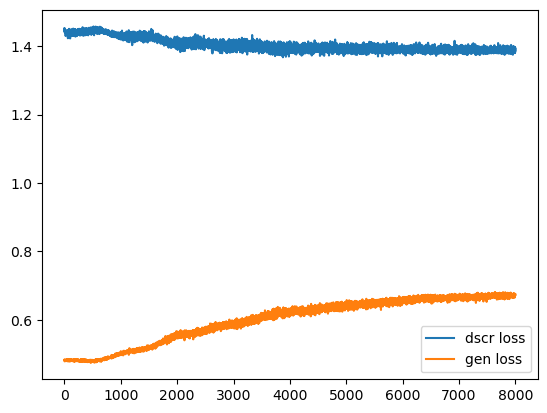

[ Info: Epoch 1: train step: 0, dscr loss: 1.453722189695994, gen loss: 0.4534148553704476
[ Info: Epoch 6: train step: 200, dscr loss: 1.4443215201813104, gen loss: 0.46771965665098797
[ Info: Epoch 11: train step: 400, dscr loss: 1.4396187408013792, gen loss: 0.4874364297598901
[ Info: Epoch 16: train step: 600, dscr loss: 1.4168548974251078, gen loss: 0.4958317272752255
[ Info: Epoch 21: train step: 800, dscr loss: 1.411977052781681, gen loss: 0.5026219086956538
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4037796614692046, gen loss: 0.5106377871389932
[ Info: Epoch 31: train step: 1200, dscr loss: 1.42405914403715, gen loss: 0.5226648265000169
[ Info: Epoch 36: train step: 1400, dscr loss: 1.417129600580689, gen loss: 0.5349441160786338
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4055419192128416, gen loss: 0.5381649232208232
[ Info: Epoch 46: train step: 1800, dscr loss: 1.439870771590807, gen loss: 0.5512734587099068
[ Info: Epoch 51: train step: 2000, dscr loss: 1.42172

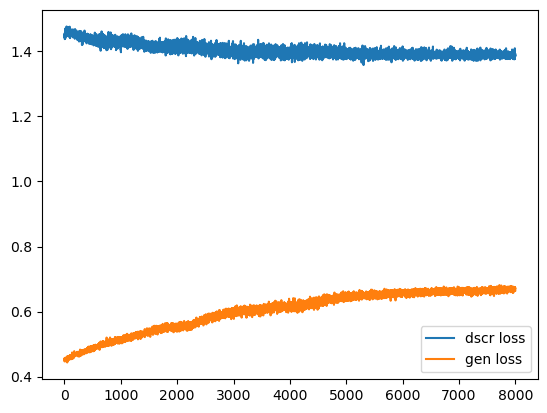

[ Info: Epoch 1: train step: 0, dscr loss: 1.4415189377939845, gen loss: 0.47687717873532015
[ Info: Epoch 6: train step: 200, dscr loss: 1.465480487831004, gen loss: 0.4867110478903596
[ Info: Epoch 11: train step: 400, dscr loss: 1.4538227225277724, gen loss: 0.4945152660158923
[ Info: Epoch 16: train step: 600, dscr loss: 1.4459659524657993, gen loss: 0.5034811416209672
[ Info: Epoch 21: train step: 800, dscr loss: 1.4292494041275825, gen loss: 0.5137967672180797
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4287669882107492, gen loss: 0.5200811693531024
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4211981909441955, gen loss: 0.5242086971784342
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4116335170902703, gen loss: 0.5219819170114822
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4123951873638332, gen loss: 0.5269637175540774
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4054446378298011, gen loss: 0.5304262240177067
[ Info: Epoch 51: train step: 2000, dscr loss: 1.

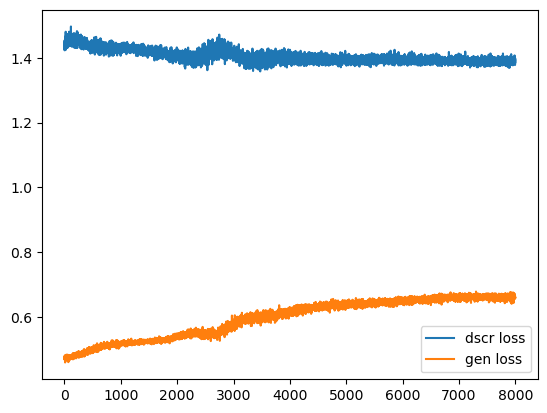

[ Info: Epoch 1: train step: 0, dscr loss: 1.4636147885397808, gen loss: 0.44536531461256046
[ Info: Epoch 6: train step: 200, dscr loss: 1.4725557797674758, gen loss: 0.4562969115613894
[ Info: Epoch 11: train step: 400, dscr loss: 1.4676347620515025, gen loss: 0.4595037047753131
[ Info: Epoch 16: train step: 600, dscr loss: 1.4248702237995747, gen loss: 0.47858007136112346
[ Info: Epoch 21: train step: 800, dscr loss: 1.4349012686068767, gen loss: 0.4898007076444308
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4136774832007233, gen loss: 0.5007382199501424
[ Info: Epoch 31: train step: 1200, dscr loss: 1.410562853422241, gen loss: 0.509213596735428
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4101220678427007, gen loss: 0.5155934054746513
[ Info: Epoch 41: train step: 1600, dscr loss: 1.407916329031587, gen loss: 0.5257878502869834
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4174660102376875, gen loss: 0.5361153006818659
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4

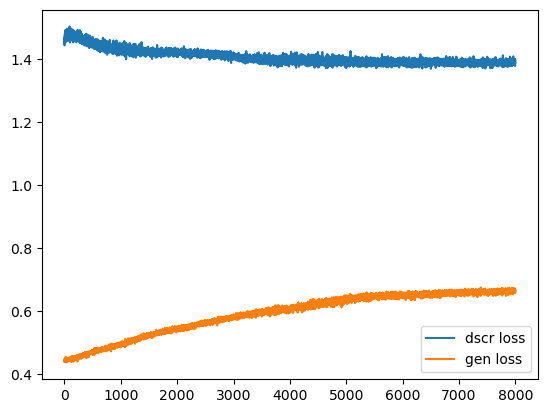

[ Info: Epoch 1: train step: 0, dscr loss: 1.4446473056566616, gen loss: 0.46700229280369415
[ Info: Epoch 6: train step: 200, dscr loss: 1.437690260631097, gen loss: 0.4730634865265096
[ Info: Epoch 11: train step: 400, dscr loss: 1.453722294978967, gen loss: 0.47331137979725585
[ Info: Epoch 16: train step: 600, dscr loss: 1.4636675525975442, gen loss: 0.48204039369024143
[ Info: Epoch 21: train step: 800, dscr loss: 1.4468882440921758, gen loss: 0.4893335606688987
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4521016886583313, gen loss: 0.49463294844149175
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4337932829556177, gen loss: 0.5103310954524702
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4213797216201425, gen loss: 0.5160871531576975
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4187436563940277, gen loss: 0.5254961739108951
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4234211913589245, gen loss: 0.5370300300812823
[ Info: Epoch 51: train step: 2000, dscr loss: 

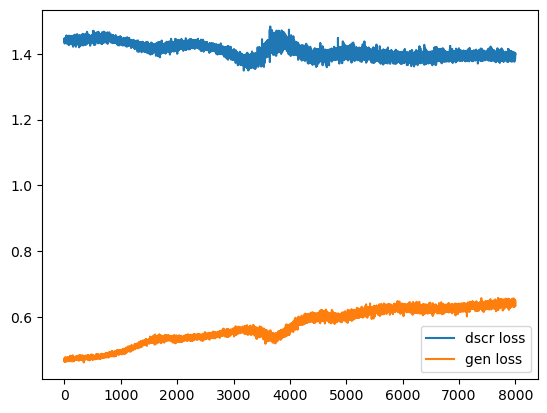

[ Info: Epoch 1: train step: 0, dscr loss: 1.4482394618177592, gen loss: 0.4851988064657428
[ Info: Epoch 6: train step: 200, dscr loss: 1.4299998193992998, gen loss: 0.48722015239385635
[ Info: Epoch 11: train step: 400, dscr loss: 1.4505154571112435, gen loss: 0.49959762438524163
[ Info: Epoch 16: train step: 600, dscr loss: 1.4325662524886087, gen loss: 0.5085083522064786
[ Info: Epoch 21: train step: 800, dscr loss: 1.4257660575811473, gen loss: 0.5294432422772326
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4172955243529755, gen loss: 0.528820312627073
[ Info: Epoch 31: train step: 1200, dscr loss: 1.446013650002476, gen loss: 0.5363445957300863
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4259854701112342, gen loss: 0.5395568130482538
[ Info: Epoch 41: train step: 1600, dscr loss: 1.3994302353381922, gen loss: 0.5520225652368225
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3959605100947048, gen loss: 0.5678930467455274
[ Info: Epoch 51: train step: 2000, dscr loss: 1.

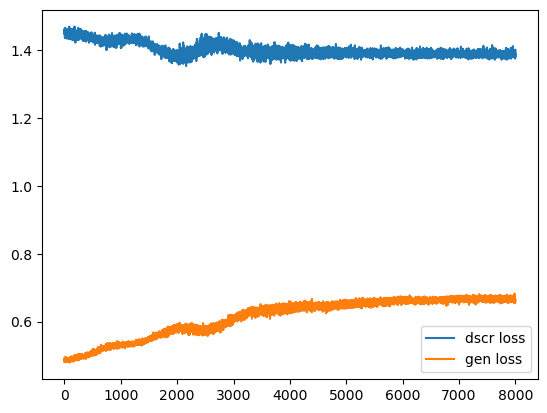

[ Info: Epoch 1: train step: 0, dscr loss: 1.4182677618031254, gen loss: 0.4941253612110217
[ Info: Epoch 6: train step: 200, dscr loss: 1.4459893133504345, gen loss: 0.4984241402083328
[ Info: Epoch 11: train step: 400, dscr loss: 1.4472091721106581, gen loss: 0.5033202322066457
[ Info: Epoch 16: train step: 600, dscr loss: 1.4467758897809517, gen loss: 0.4950777172743511
[ Info: Epoch 21: train step: 800, dscr loss: 1.4539222742167945, gen loss: 0.49644272372519965
[ Info: Epoch 26: train step: 1000, dscr loss: 1.438427191556109, gen loss: 0.5073236500890018
[ Info: Epoch 31: train step: 1200, dscr loss: 1.441690782222456, gen loss: 0.511023601597741
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4237758028692498, gen loss: 0.528280932010586
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4281474486668677, gen loss: 0.5411602633261898
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4091072595665357, gen loss: 0.5482560063104697
[ Info: Epoch 51: train step: 2000, dscr loss: 1.401

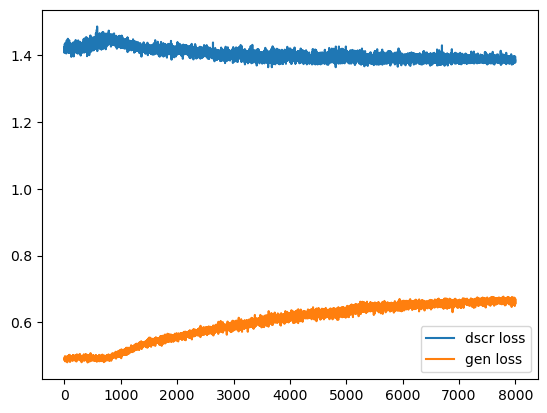

[ Info: Epoch 1: train step: 0, dscr loss: 1.4280552720496145, gen loss: 0.5587282049510316
[ Info: Epoch 6: train step: 200, dscr loss: 1.3858339655568614, gen loss: 0.5602245378869736
[ Info: Epoch 11: train step: 400, dscr loss: 1.4080282048259058, gen loss: 0.5731114964833097
[ Info: Epoch 16: train step: 600, dscr loss: 1.4140381731684746, gen loss: 0.5676285362042194
[ Info: Epoch 21: train step: 800, dscr loss: 1.4052113177316319, gen loss: 0.5683476659982976
[ Info: Epoch 26: train step: 1000, dscr loss: 1.42609785299453, gen loss: 0.5579885443127632
[ Info: Epoch 31: train step: 1200, dscr loss: 1.412390895054224, gen loss: 0.5617954383860649
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4212868066846451, gen loss: 0.5738610869562923
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4028024413559164, gen loss: 0.5846658618209918
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4096251545572516, gen loss: 0.6039844921131088
[ Info: Epoch 51: train step: 2000, dscr loss: 1.388

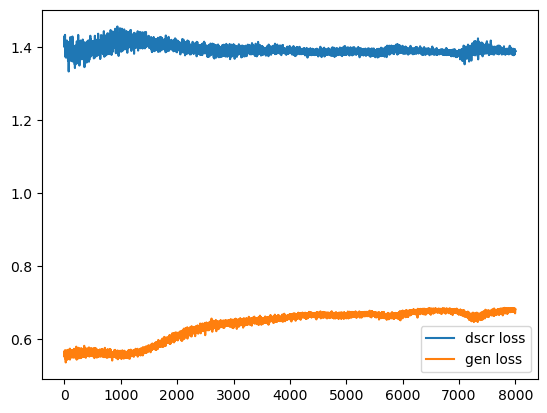

[ Info: Epoch 1: train step: 0, dscr loss: 1.4465407792563, gen loss: 0.4445642541521417
[ Info: Epoch 6: train step: 200, dscr loss: 1.4960560731912838, gen loss: 0.4494730816335699
[ Info: Epoch 11: train step: 400, dscr loss: 1.4413421777411053, gen loss: 0.45502559956096195
[ Info: Epoch 16: train step: 600, dscr loss: 1.444672694565828, gen loss: 0.4838451226834121
[ Info: Epoch 21: train step: 800, dscr loss: 1.4131700402275984, gen loss: 0.4969925544973567
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4141458039646875, gen loss: 0.5089343897303911
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4355353059818716, gen loss: 0.5243488822700724
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4289163656394903, gen loss: 0.5188008708717793
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4297726947173053, gen loss: 0.5270598331871278
[ Info: Epoch 46: train step: 1800, dscr loss: 1.441652748561153, gen loss: 0.5398109100269441
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4224

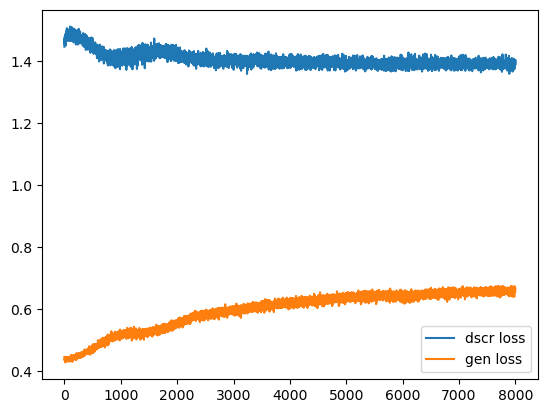

[ Info: Epoch 1: train step: 0, dscr loss: 1.4359988174143585, gen loss: 0.48296472854768635
[ Info: Epoch 6: train step: 200, dscr loss: 1.4295112953866993, gen loss: 0.4927685039850271
[ Info: Epoch 11: train step: 400, dscr loss: 1.4293229771067963, gen loss: 0.4885911745603615
[ Info: Epoch 16: train step: 600, dscr loss: 1.438151775267809, gen loss: 0.485360034556196
[ Info: Epoch 21: train step: 800, dscr loss: 1.4378537999893557, gen loss: 0.5087305971485813
[ Info: Epoch 26: train step: 1000, dscr loss: 1.431285838542092, gen loss: 0.5148472005507979
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4451536267277496, gen loss: 0.5209292579418617
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4376068799110593, gen loss: 0.5228228166401945
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4231327456825298, gen loss: 0.5230742748978793
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4176822873005968, gen loss: 0.5265425678067107
[ Info: Epoch 51: train step: 2000, dscr loss: 1.41

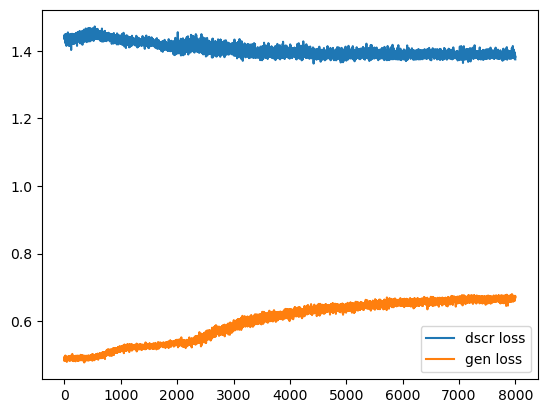

[ Info: Epoch 1: train step: 0, dscr loss: 1.453372642129979, gen loss: 0.4696768122550571
[ Info: Epoch 6: train step: 200, dscr loss: 1.4417936808582317, gen loss: 0.4682806799414873
[ Info: Epoch 11: train step: 400, dscr loss: 1.4394174813633094, gen loss: 0.4801065953508926
[ Info: Epoch 16: train step: 600, dscr loss: 1.4303939581285736, gen loss: 0.49987286843864254
[ Info: Epoch 21: train step: 800, dscr loss: 1.437939864086015, gen loss: 0.5018893814143907
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4400411156138337, gen loss: 0.5191923315619116
[ Info: Epoch 31: train step: 1200, dscr loss: 1.428914426818959, gen loss: 0.5204006158590517
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4212311797672676, gen loss: 0.5333744583037695
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4159520765306453, gen loss: 0.5345611101670977
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4139808628275214, gen loss: 0.5335860524431092
[ Info: Epoch 51: train step: 2000, dscr loss: 1.41

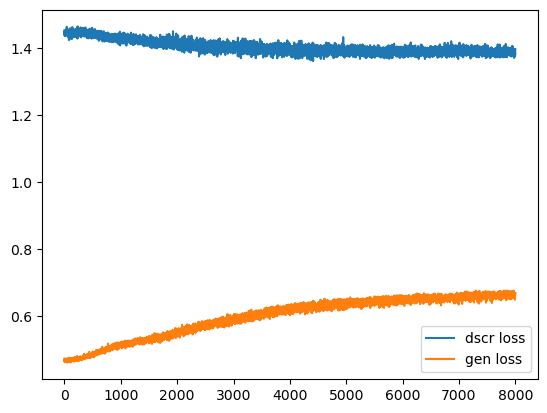

[ Info: Epoch 1: train step: 0, dscr loss: 1.4585308488831281, gen loss: 0.4757502688645719
[ Info: Epoch 6: train step: 200, dscr loss: 1.466478714371025, gen loss: 0.4825748296612284
[ Info: Epoch 11: train step: 400, dscr loss: 1.4683330105612287, gen loss: 0.4953255234172488
[ Info: Epoch 16: train step: 600, dscr loss: 1.4529451649462177, gen loss: 0.5093147020716249
[ Info: Epoch 21: train step: 800, dscr loss: 1.4481874587500745, gen loss: 0.5129820776652277
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4346121561091416, gen loss: 0.5141167608775157
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4301797657254944, gen loss: 0.5239329258267753
[ Info: Epoch 36: train step: 1400, dscr loss: 1.400309976355053, gen loss: 0.5352042446021347
[ Info: Epoch 41: train step: 1600, dscr loss: 1.3878919020180391, gen loss: 0.5535508577532091
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3944265364552866, gen loss: 0.5516564527557769
[ Info: Epoch 51: train step: 2000, dscr loss: 1.41

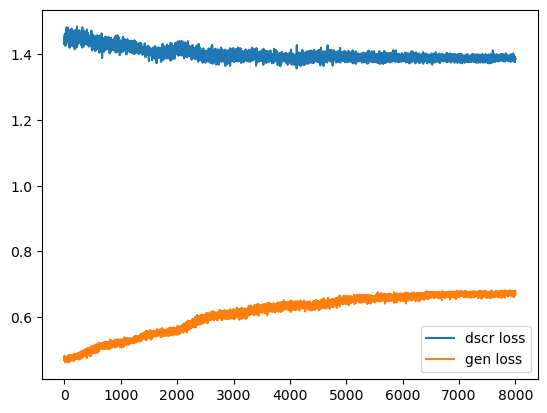

[ Info: Epoch 1: train step: 0, dscr loss: 1.4620541326482146, gen loss: 0.4569397844771097
[ Info: Epoch 6: train step: 200, dscr loss: 1.4519729510287667, gen loss: 0.46919125959262475
[ Info: Epoch 11: train step: 400, dscr loss: 1.430786633750591, gen loss: 0.4829993389462501
[ Info: Epoch 16: train step: 600, dscr loss: 1.4383794759530149, gen loss: 0.4893064535943958
[ Info: Epoch 21: train step: 800, dscr loss: 1.4216163345016146, gen loss: 0.502552127048166
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4393809715885069, gen loss: 0.5051719427858202
[ Info: Epoch 31: train step: 1200, dscr loss: 1.448917621268527, gen loss: 0.5047107871861674
[ Info: Epoch 36: train step: 1400, dscr loss: 1.430108025719357, gen loss: 0.5187855870820951
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4368108143409748, gen loss: 0.5322174847655741
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4055947779508222, gen loss: 0.5424012587816202
[ Info: Epoch 51: train step: 2000, dscr loss: 1.397

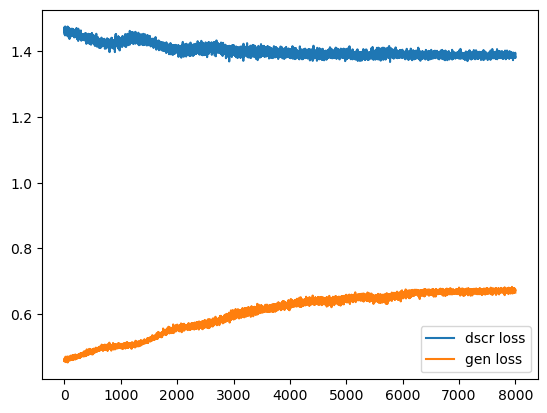

[ Info: Epoch 1: train step: 0, dscr loss: 1.4908215906526514, gen loss: 0.4855932368529689
[ Info: Epoch 6: train step: 200, dscr loss: 1.4828340599417709, gen loss: 0.49474722954445854
[ Info: Epoch 11: train step: 400, dscr loss: 1.469802352980456, gen loss: 0.4925546466103701
[ Info: Epoch 16: train step: 600, dscr loss: 1.4303628422593966, gen loss: 0.5097419702416695
[ Info: Epoch 21: train step: 800, dscr loss: 1.4392685249846005, gen loss: 0.5140226048787917
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4126675171844776, gen loss: 0.5157850460631078
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4220935046603569, gen loss: 0.5183068404445808
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4155992693574397, gen loss: 0.5315026407158261
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4115734916461071, gen loss: 0.5489120052809143
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4222254978619762, gen loss: 0.5475461380212964
[ Info: Epoch 51: train step: 2000, dscr loss: 1.

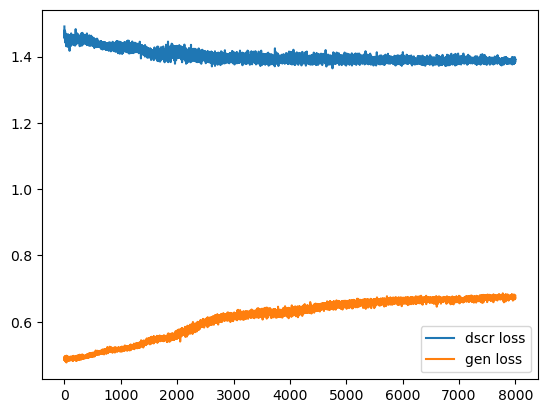

[ Info: Epoch 1: train step: 0, dscr loss: 1.437085410684958, gen loss: 0.46626206121255764
[ Info: Epoch 6: train step: 200, dscr loss: 1.4152536344137674, gen loss: 0.46707207972692016
[ Info: Epoch 11: train step: 400, dscr loss: 1.4187310740055428, gen loss: 0.4784382618789173
[ Info: Epoch 16: train step: 600, dscr loss: 1.429044638966214, gen loss: 0.47636790044525057
[ Info: Epoch 21: train step: 800, dscr loss: 1.4406327263737508, gen loss: 0.48157307865793086
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4200721337806341, gen loss: 0.49848425369922167
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4253135375573112, gen loss: 0.5076986920421693
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4237981129814052, gen loss: 0.5298528322615067
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4155491581177548, gen loss: 0.533807687361895
[ Info: Epoch 46: train step: 1800, dscr loss: 1.430949500115404, gen loss: 0.5391086982914852
[ Info: Epoch 51: train step: 2000, dscr loss: 1

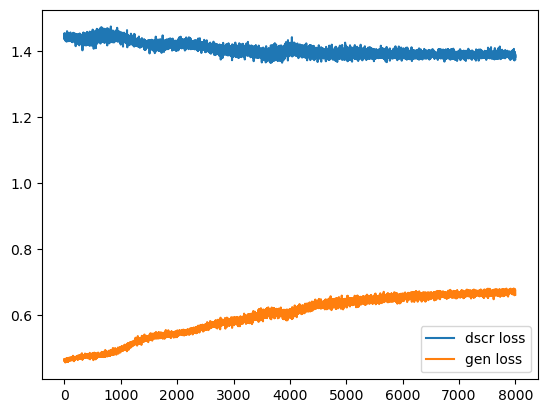

[ Info: Epoch 1: train step: 0, dscr loss: 1.4598332995092775, gen loss: 0.49899404289091004
[ Info: Epoch 6: train step: 200, dscr loss: 1.4110694239874988, gen loss: 0.5257341747874402
[ Info: Epoch 11: train step: 400, dscr loss: 1.43537433515937, gen loss: 0.5389716995215355
[ Info: Epoch 16: train step: 600, dscr loss: 1.441376101817443, gen loss: 0.516816460182682
[ Info: Epoch 21: train step: 800, dscr loss: 1.488382027546988, gen loss: 0.5163957990514965
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4909716405367, gen loss: 0.5049504568120774
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4758188190765174, gen loss: 0.5088789826426514
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4681885867358626, gen loss: 0.5227994594980399
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4234645194769011, gen loss: 0.5417127560788845
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3910298550991294, gen loss: 0.5655660977513375
[ Info: Epoch 51: train step: 2000, dscr loss: 1.3714372

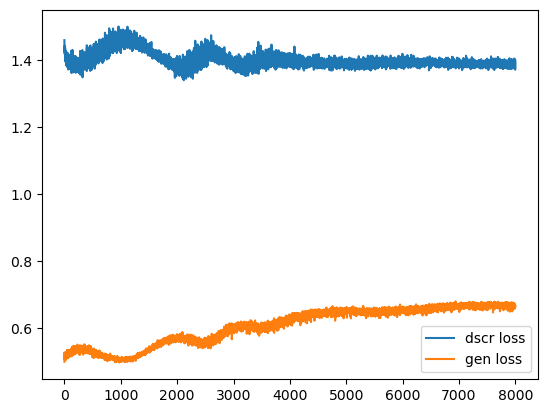

[ Info: Epoch 1: train step: 0, dscr loss: 1.4326655580873195, gen loss: 0.4939930946865739
[ Info: Epoch 6: train step: 200, dscr loss: 1.4307074968108662, gen loss: 0.49924443767930327
[ Info: Epoch 11: train step: 400, dscr loss: 1.4239184634766993, gen loss: 0.5039971154118761
[ Info: Epoch 16: train step: 600, dscr loss: 1.4357575403439446, gen loss: 0.5092307739665706
[ Info: Epoch 21: train step: 800, dscr loss: 1.4469044504989823, gen loss: 0.5204225415224554
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4377727735354022, gen loss: 0.5381620145459354
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4249893146032302, gen loss: 0.5527509384538019
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4121224600126039, gen loss: 0.5595118902843927
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4017498714001575, gen loss: 0.5795732397430662
[ Info: Epoch 46: train step: 1800, dscr loss: 1.395191411116325, gen loss: 0.5900541686220433
[ Info: Epoch 51: train step: 2000, dscr loss: 1.

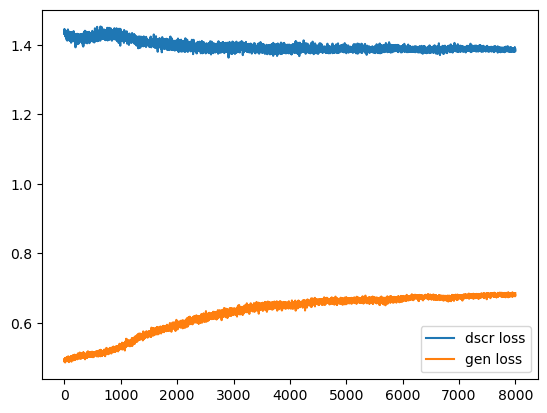

[ Info: Epoch 1: train step: 0, dscr loss: 1.4146730528432452, gen loss: 0.49172304298044717
[ Info: Epoch 6: train step: 200, dscr loss: 1.4149150947758085, gen loss: 0.49120278140130935
[ Info: Epoch 11: train step: 400, dscr loss: 1.4299366921507461, gen loss: 0.4909930525281437
[ Info: Epoch 16: train step: 600, dscr loss: 1.4382358228640943, gen loss: 0.49800482129398804
[ Info: Epoch 21: train step: 800, dscr loss: 1.4288013000296043, gen loss: 0.5013618579414166
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4266025055660765, gen loss: 0.5055953419532024
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4213729042023422, gen loss: 0.5163435788574137
[ Info: Epoch 36: train step: 1400, dscr loss: 1.433174630021397, gen loss: 0.5161561993600314
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4143418511203494, gen loss: 0.533603881997147
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4193208892160767, gen loss: 0.5453337802552235
[ Info: Epoch 51: train step: 2000, dscr loss: 1

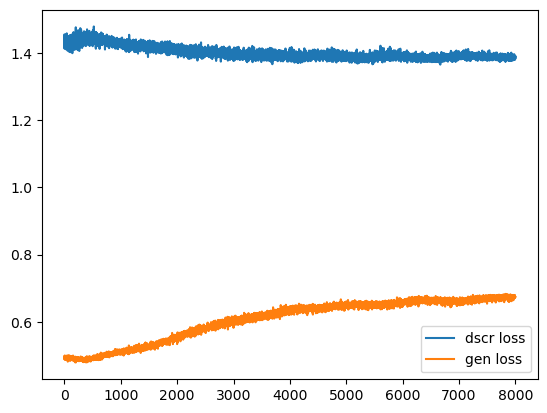

[ Info: Epoch 1: train step: 0, dscr loss: 1.4698734377287197, gen loss: 0.45300639373839036
[ Info: Epoch 6: train step: 200, dscr loss: 1.4676769019932965, gen loss: 0.4721544120090438
[ Info: Epoch 11: train step: 400, dscr loss: 1.430902383203812, gen loss: 0.4911244077766608
[ Info: Epoch 16: train step: 600, dscr loss: 1.4178796070240531, gen loss: 0.4987624684595171
[ Info: Epoch 21: train step: 800, dscr loss: 1.4180338222904807, gen loss: 0.5112694261676252
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4180502014356768, gen loss: 0.5067409721473721
[ Info: Epoch 31: train step: 1200, dscr loss: 1.41244213995942, gen loss: 0.512781012250492
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4310766263054362, gen loss: 0.5077420441252479
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4339893782563, gen loss: 0.5104039371163762
[ Info: Epoch 46: train step: 1800, dscr loss: 1.43076369367785, gen loss: 0.5162416121590537
[ Info: Epoch 51: train step: 2000, dscr loss: 1.43067310

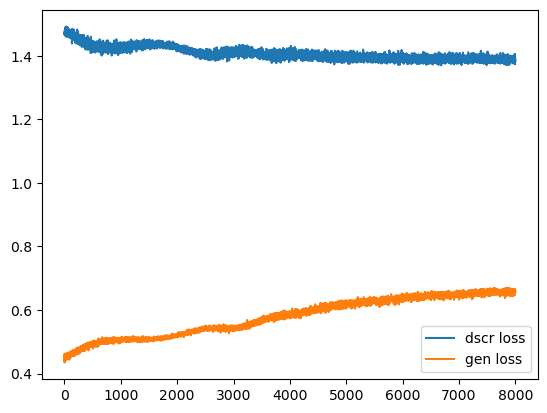

[ Info: Epoch 1: train step: 0, dscr loss: 1.4567485219819458, gen loss: 0.4719124363857162
[ Info: Epoch 6: train step: 200, dscr loss: 1.438145896262208, gen loss: 0.49129134175134304
[ Info: Epoch 11: train step: 400, dscr loss: 1.4361336376860008, gen loss: 0.4974613313080907
[ Info: Epoch 16: train step: 600, dscr loss: 1.4297719258960908, gen loss: 0.5041376415211317
[ Info: Epoch 21: train step: 800, dscr loss: 1.4231202426304252, gen loss: 0.5039653180087795
[ Info: Epoch 26: train step: 1000, dscr loss: 1.427665923794075, gen loss: 0.5005361254598867
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4202505130213656, gen loss: 0.5068244548154284
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4164579612459636, gen loss: 0.5033023006999775
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4426472242220618, gen loss: 0.5164498379057335
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4280405410918142, gen loss: 0.5201181336990212
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4

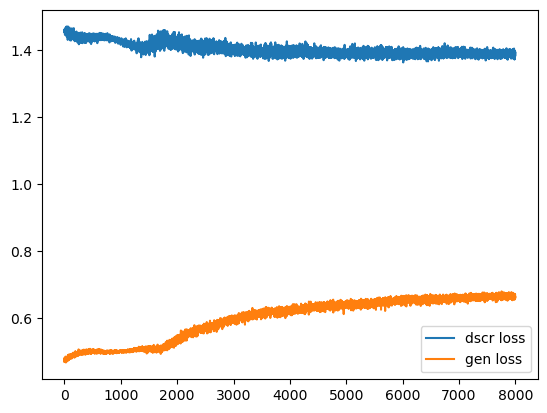

[ Info: Epoch 1: train step: 0, dscr loss: 1.4597583370263902, gen loss: 0.5007408827357382
[ Info: Epoch 6: train step: 200, dscr loss: 1.4447449582413283, gen loss: 0.499491032506032
[ Info: Epoch 11: train step: 400, dscr loss: 1.4463279283195978, gen loss: 0.5054099519937132
[ Info: Epoch 16: train step: 600, dscr loss: 1.4442840258254712, gen loss: 0.5023108906541761
[ Info: Epoch 21: train step: 800, dscr loss: 1.4470221821509688, gen loss: 0.5072401097225443
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4360908604644291, gen loss: 0.5225875655991653
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4196338363418661, gen loss: 0.5338469664920598
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4072585806029219, gen loss: 0.5419967982625418
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4179901982937069, gen loss: 0.5570281539631126
[ Info: Epoch 46: train step: 1800, dscr loss: 1.407228776335852, gen loss: 0.5604531605024463
[ Info: Epoch 51: train step: 2000, dscr loss: 1.41

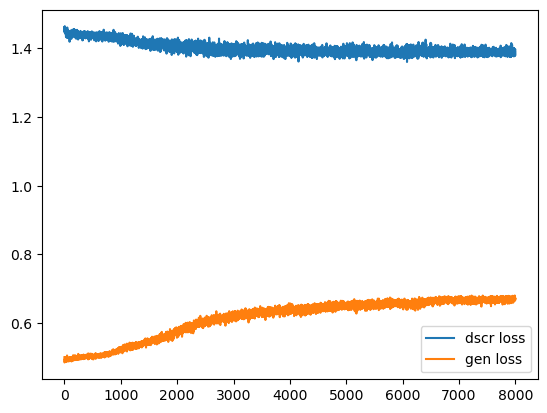

[ Info: Epoch 1: train step: 0, dscr loss: 1.450658409924774, gen loss: 0.4797934215758164
[ Info: Epoch 6: train step: 200, dscr loss: 1.4412810477314522, gen loss: 0.49474802003027946
[ Info: Epoch 11: train step: 400, dscr loss: 1.4316973596324616, gen loss: 0.5052596991883099
[ Info: Epoch 16: train step: 600, dscr loss: 1.4206710296634817, gen loss: 0.5064294594662127
[ Info: Epoch 21: train step: 800, dscr loss: 1.4263162692908098, gen loss: 0.5027327813784055
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4296065725291025, gen loss: 0.5072164200665192
[ Info: Epoch 31: train step: 1200, dscr loss: 1.42639760248818, gen loss: 0.5136835405270443
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4151993418177145, gen loss: 0.5185516687556351
[ Info: Epoch 41: train step: 1600, dscr loss: 1.409642585483455, gen loss: 0.5325551606486896
[ Info: Epoch 46: train step: 1800, dscr loss: 1.412834318273269, gen loss: 0.5392154571429536
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4054

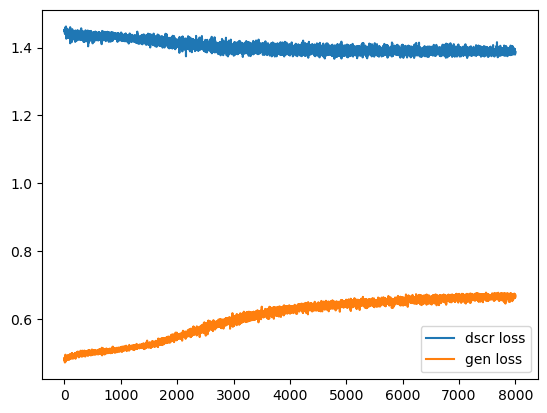

[ Info: Epoch 1: train step: 0, dscr loss: 1.4355874658409744, gen loss: 0.46030548817368455
[ Info: Epoch 6: train step: 200, dscr loss: 1.4496956054721901, gen loss: 0.4633267156778531
[ Info: Epoch 11: train step: 400, dscr loss: 1.4479339202014425, gen loss: 0.471955484402731
[ Info: Epoch 16: train step: 600, dscr loss: 1.4265450120363212, gen loss: 0.47493952435936093
[ Info: Epoch 21: train step: 800, dscr loss: 1.444839553490707, gen loss: 0.49846231973765626
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4386360093283337, gen loss: 0.49656475162102737
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4343558662582219, gen loss: 0.511876274136759
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4405035169208027, gen loss: 0.5327395820351859
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4349501242275755, gen loss: 0.5316465223457569
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4239023660561934, gen loss: 0.5428134569683183
[ Info: Epoch 51: train step: 2000, dscr loss: 1

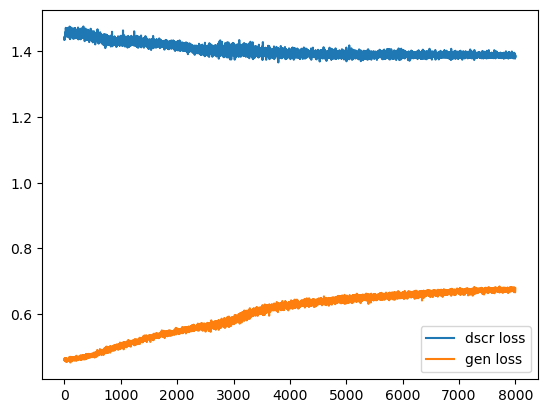

[ Info: Epoch 1: train step: 0, dscr loss: 1.4667888439491474, gen loss: 0.4625469512046276
[ Info: Epoch 6: train step: 200, dscr loss: 1.4516083547727316, gen loss: 0.48107903977752137
[ Info: Epoch 11: train step: 400, dscr loss: 1.4350382873865275, gen loss: 0.49675924028162016
[ Info: Epoch 16: train step: 600, dscr loss: 1.4354618964835377, gen loss: 0.4982666023104517
[ Info: Epoch 21: train step: 800, dscr loss: 1.4281651253934042, gen loss: 0.5136038157706052
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4291844370394835, gen loss: 0.5146634013312139
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4520264405872365, gen loss: 0.5043496676353033
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4467087236513982, gen loss: 0.505127744150042
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4447787585968634, gen loss: 0.5112928206821858
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4379339460344676, gen loss: 0.5260595052028139
[ Info: Epoch 51: train step: 2000, dscr loss: 1

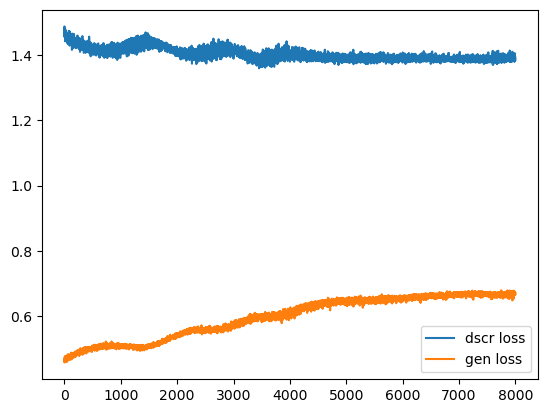

[ Info: Epoch 1: train step: 0, dscr loss: 1.4345271303677112, gen loss: 0.4590008084304211
[ Info: Epoch 6: train step: 200, dscr loss: 1.4288218913749828, gen loss: 0.4747364037479906
[ Info: Epoch 11: train step: 400, dscr loss: 1.4330853392312262, gen loss: 0.4781420489988658
[ Info: Epoch 16: train step: 600, dscr loss: 1.440372787866521, gen loss: 0.4891109130530373
[ Info: Epoch 21: train step: 800, dscr loss: 1.4253755186249815, gen loss: 0.4841455235226026
[ Info: Epoch 26: train step: 1000, dscr loss: 1.424676600613566, gen loss: 0.492206276886103
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4326052734278811, gen loss: 0.5002013961189224
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4317967670789056, gen loss: 0.5095262294925144
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4213452259691608, gen loss: 0.525138775566898
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4127083834949599, gen loss: 0.5310981513284712
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4048

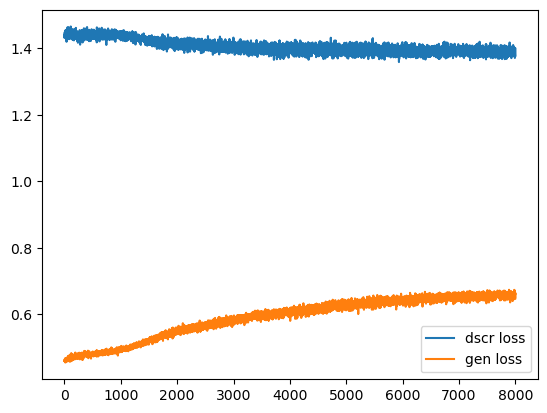

[ Info: Epoch 1: train step: 0, dscr loss: 1.4658881580830991, gen loss: 0.4725742789816789
[ Info: Epoch 6: train step: 200, dscr loss: 1.4510701991620767, gen loss: 0.4959442199978342
[ Info: Epoch 11: train step: 400, dscr loss: 1.4435944097379512, gen loss: 0.50775234631592
[ Info: Epoch 16: train step: 600, dscr loss: 1.4426238039079697, gen loss: 0.5042913554479983
[ Info: Epoch 21: train step: 800, dscr loss: 1.447374542742461, gen loss: 0.5177139003062683
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4427697749454882, gen loss: 0.5026505356359319
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4286810733102548, gen loss: 0.5061480879173564
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4198036968558987, gen loss: 0.5241346711131476
[ Info: Epoch 41: train step: 1600, dscr loss: 1.3984576848488786, gen loss: 0.5287947585984076
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3934787032218747, gen loss: 0.5330714773771164
[ Info: Epoch 51: train step: 2000, dscr loss: 1.389

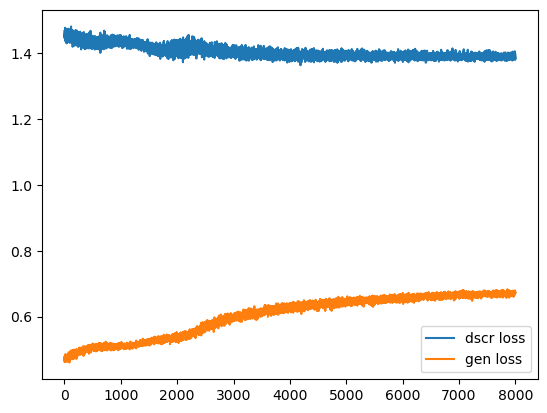

[ Info: Epoch 1: train step: 0, dscr loss: 1.4449210876171568, gen loss: 0.4747791975860291
[ Info: Epoch 6: train step: 200, dscr loss: 1.444715002637847, gen loss: 0.4765598215442248
[ Info: Epoch 11: train step: 400, dscr loss: 1.4327889974335017, gen loss: 0.4934770616780611
[ Info: Epoch 16: train step: 600, dscr loss: 1.4368645951198769, gen loss: 0.4973357151004894
[ Info: Epoch 21: train step: 800, dscr loss: 1.4434248028743357, gen loss: 0.5022126420396251
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4582066564660638, gen loss: 0.5118676977847894
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4309500046316175, gen loss: 0.5169072329941422
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4187707839730317, gen loss: 0.5299093179765443
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4139307055507162, gen loss: 0.5499524676879883
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3946897300147045, gen loss: 0.5589789087448839
[ Info: Epoch 51: train step: 2000, dscr loss: 1.3

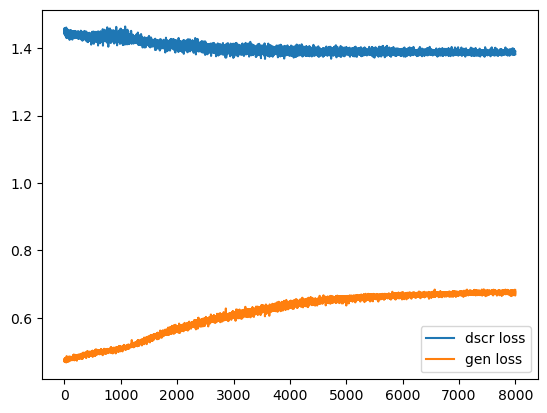

[ Info: Epoch 1: train step: 0, dscr loss: 1.4542973549892808, gen loss: 0.464547706573319
[ Info: Epoch 6: train step: 200, dscr loss: 1.4415301052437683, gen loss: 0.47025544678030073
[ Info: Epoch 11: train step: 400, dscr loss: 1.4378782465975393, gen loss: 0.47780597800074914
[ Info: Epoch 16: train step: 600, dscr loss: 1.428281229767244, gen loss: 0.4818842859132752
[ Info: Epoch 21: train step: 800, dscr loss: 1.403191429385938, gen loss: 0.4935233227468482
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4062954334817452, gen loss: 0.49300930039488255
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4273800699154924, gen loss: 0.5047033963046235
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4349926025031885, gen loss: 0.5146584815483947
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4172050084221828, gen loss: 0.5334058275401904
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4130138884423367, gen loss: 0.5389407073785933
[ Info: Epoch 51: train step: 2000, dscr loss: 1.

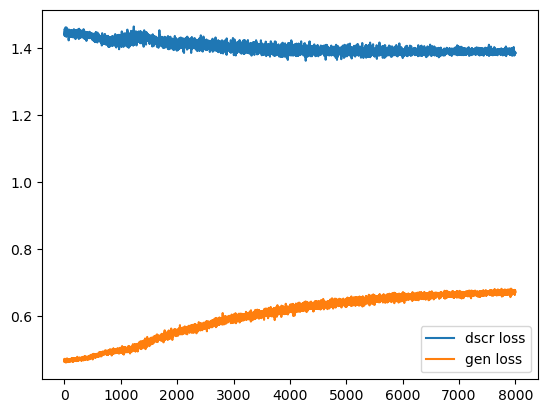

[ Info: Epoch 1: train step: 0, dscr loss: 1.4387210846026455, gen loss: 0.5116122910370856
[ Info: Epoch 6: train step: 200, dscr loss: 1.422771050222679, gen loss: 0.5228178591874588
[ Info: Epoch 11: train step: 400, dscr loss: 1.4377352647851485, gen loss: 0.5125114400883125
[ Info: Epoch 16: train step: 600, dscr loss: 1.4456857376385401, gen loss: 0.5050533424018533
[ Info: Epoch 21: train step: 800, dscr loss: 1.4419159069078016, gen loss: 0.49993431299776003
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4585459150708275, gen loss: 0.49526612590389363
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4437251994253701, gen loss: 0.4946381179772806
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4387947168691537, gen loss: 0.512245701820601
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4298872208267073, gen loss: 0.5131011546953477
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4178412405295813, gen loss: 0.5256403273389526
[ Info: Epoch 51: train step: 2000, dscr loss: 1.

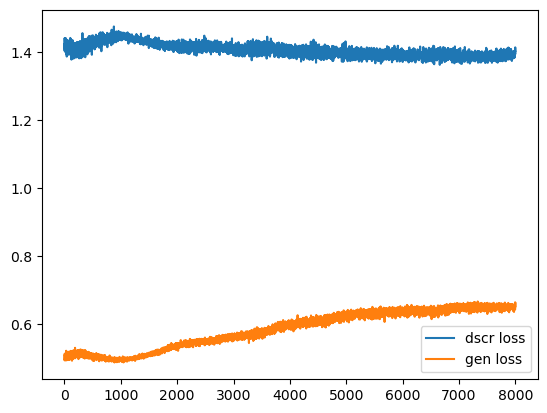

[ Info: Epoch 1: train step: 0, dscr loss: 1.4514560055731582, gen loss: 0.4794841174524043
[ Info: Epoch 6: train step: 200, dscr loss: 1.4280638596728543, gen loss: 0.5039181049762795
[ Info: Epoch 11: train step: 400, dscr loss: 1.4172992039973162, gen loss: 0.5059910360622151
[ Info: Epoch 16: train step: 600, dscr loss: 1.415403516461893, gen loss: 0.5132705273653291
[ Info: Epoch 21: train step: 800, dscr loss: 1.4173861091078104, gen loss: 0.518865940235684
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4264063847522062, gen loss: 0.5332251586554908
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4171720984030225, gen loss: 0.5497339222158694
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4120906011778966, gen loss: 0.557242601873755
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4179810261688437, gen loss: 0.5646714787591601
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4211673421172493, gen loss: 0.5828622975281887
[ Info: Epoch 51: train step: 2000, dscr loss: 1.407

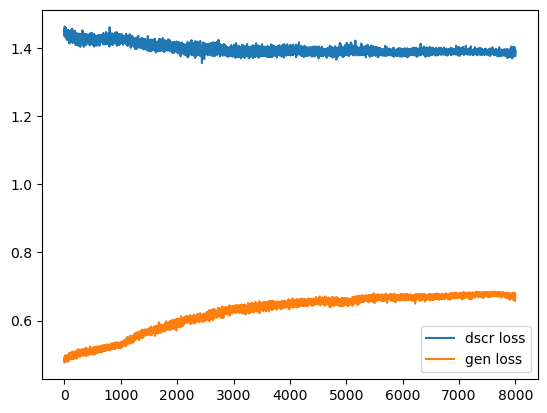

[ Info: Epoch 1: train step: 0, dscr loss: 1.480994437903557, gen loss: 0.4348938577146154
[ Info: Epoch 6: train step: 200, dscr loss: 1.4772704916265902, gen loss: 0.448668278866352
[ Info: Epoch 11: train step: 400, dscr loss: 1.4641999241547934, gen loss: 0.4708708236313862
[ Info: Epoch 16: train step: 600, dscr loss: 1.4652978456868433, gen loss: 0.4835555822159661
[ Info: Epoch 21: train step: 800, dscr loss: 1.4285483397566545, gen loss: 0.5042757777419259
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4254085453098742, gen loss: 0.5094480581830457
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4307010873956887, gen loss: 0.5098050426205993
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4298316893257295, gen loss: 0.5235830429687048
[ Info: Epoch 41: train step: 1600, dscr loss: 1.41586313527359, gen loss: 0.5428831790077269
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4023449338620768, gen loss: 0.5466884609828612
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4071

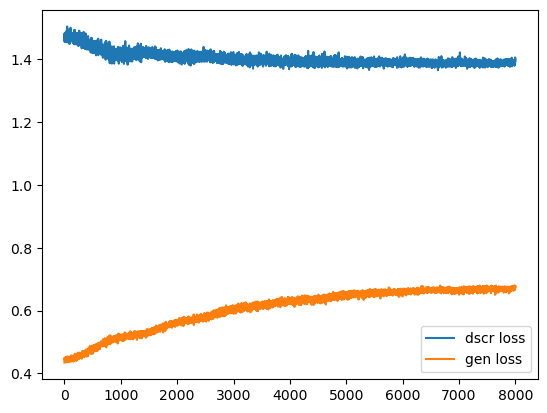

[ Info: Epoch 1: train step: 0, dscr loss: 1.443181149247351, gen loss: 0.47935189870885414
[ Info: Epoch 6: train step: 200, dscr loss: 1.4450814488591015, gen loss: 0.4818999934276318
[ Info: Epoch 11: train step: 400, dscr loss: 1.4397159818070182, gen loss: 0.4917002427421657
[ Info: Epoch 16: train step: 600, dscr loss: 1.432072847633373, gen loss: 0.5029753298846308
[ Info: Epoch 21: train step: 800, dscr loss: 1.4301634739363995, gen loss: 0.5200345549141925
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4174936841519297, gen loss: 0.5339604066977113
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4186384258706757, gen loss: 0.5502199154788573
[ Info: Epoch 36: train step: 1400, dscr loss: 1.3926641560015867, gen loss: 0.5537763089949412
[ Info: Epoch 41: train step: 1600, dscr loss: 1.3877753877894803, gen loss: 0.5791368496797368
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3913875360137409, gen loss: 0.5950501020697427
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4

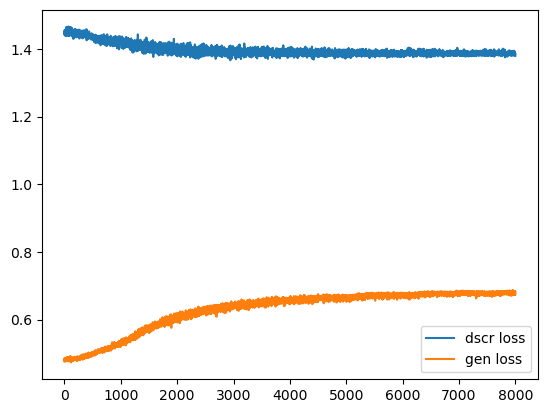

[ Info: Epoch 1: train step: 0, dscr loss: 1.4318032631687863, gen loss: 0.4646157517095469
[ Info: Epoch 6: train step: 200, dscr loss: 1.4490385266784314, gen loss: 0.4619704670028949
[ Info: Epoch 11: train step: 400, dscr loss: 1.4395038785688152, gen loss: 0.47695768880843653
[ Info: Epoch 16: train step: 600, dscr loss: 1.4069820567794131, gen loss: 0.48090707223769696
[ Info: Epoch 21: train step: 800, dscr loss: 1.4373727843207598, gen loss: 0.4895252662843748
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4135922282193087, gen loss: 0.5095668777664961
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4118549757626324, gen loss: 0.5170034400633537
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4311327186001206, gen loss: 0.5429423275203504
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4313443695537758, gen loss: 0.5445889940422985
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4377018959004317, gen loss: 0.5432611266815295
[ Info: Epoch 51: train step: 2000, dscr loss: 

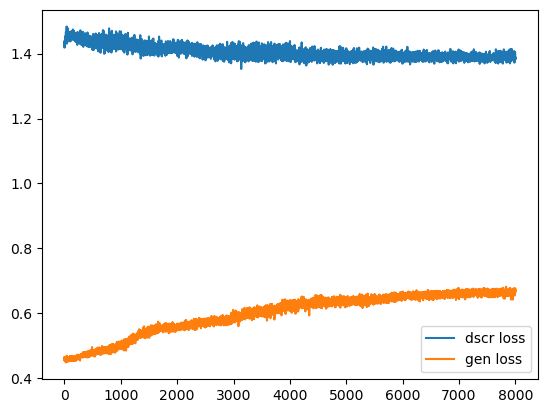

[ Info: Epoch 1: train step: 0, dscr loss: 1.4417115353706584, gen loss: 0.45576549449248843
[ Info: Epoch 6: train step: 200, dscr loss: 1.4527212045307514, gen loss: 0.46489993598547147
[ Info: Epoch 11: train step: 400, dscr loss: 1.444727622633209, gen loss: 0.47578586494042246
[ Info: Epoch 16: train step: 600, dscr loss: 1.4366425890024548, gen loss: 0.4891291795191897
[ Info: Epoch 21: train step: 800, dscr loss: 1.4355725549625804, gen loss: 0.49874285899566445
[ Info: Epoch 26: train step: 1000, dscr loss: 1.419035667785001, gen loss: 0.496728894244298
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4495816446089258, gen loss: 0.5113968119197722
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4283253684272004, gen loss: 0.5180174640588033
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4288048173515502, gen loss: 0.5362071093943199
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4102475994093078, gen loss: 0.5441227218073849
[ Info: Epoch 51: train step: 2000, dscr loss: 1

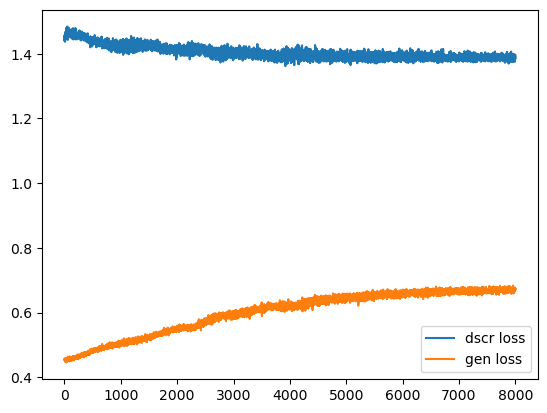

[ Info: Epoch 1: train step: 0, dscr loss: 1.446343257473694, gen loss: 0.5121892276249715
[ Info: Epoch 6: train step: 200, dscr loss: 1.4215642862098083, gen loss: 0.5276863215561169
[ Info: Epoch 11: train step: 400, dscr loss: 1.4457252702746468, gen loss: 0.5242335991860254
[ Info: Epoch 16: train step: 600, dscr loss: 1.462723371747334, gen loss: 0.521671575298923
[ Info: Epoch 21: train step: 800, dscr loss: 1.4592519476649202, gen loss: 0.5118568023713549
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4535498185396272, gen loss: 0.527211185247516
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4229908020447923, gen loss: 0.5414884378517395
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4143588300487, gen loss: 0.5497428636511673
[ Info: Epoch 41: train step: 1600, dscr loss: 1.3894923666760561, gen loss: 0.5757356027786497
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3839563006045508, gen loss: 0.586132044005781
[ Info: Epoch 51: train step: 2000, dscr loss: 1.38093859

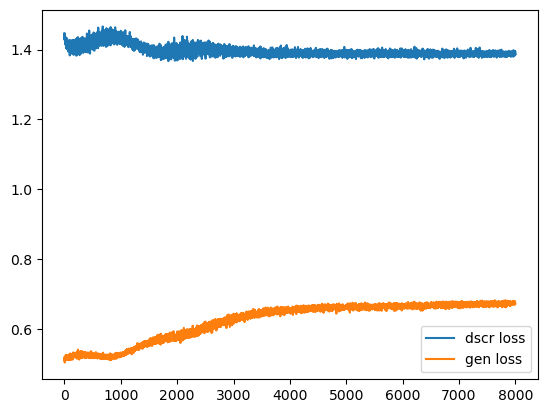

[ Info: Epoch 1: train step: 0, dscr loss: 1.4850477267414213, gen loss: 0.4605951707821025
[ Info: Epoch 6: train step: 200, dscr loss: 1.45555644936774, gen loss: 0.46653639175438355
[ Info: Epoch 11: train step: 400, dscr loss: 1.4160527837886565, gen loss: 0.4886348058292586
[ Info: Epoch 16: train step: 600, dscr loss: 1.4002007412220288, gen loss: 0.499789630043883
[ Info: Epoch 21: train step: 800, dscr loss: 1.399657303903274, gen loss: 0.5123270840767095
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4264609857669222, gen loss: 0.5161513852080937
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4421751423726097, gen loss: 0.5152490832498757
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4091379761937919, gen loss: 0.5221733524818986
[ Info: Epoch 41: train step: 1600, dscr loss: 1.425040198897501, gen loss: 0.5378805374265468
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4191290766062994, gen loss: 0.5619104921014586
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4134

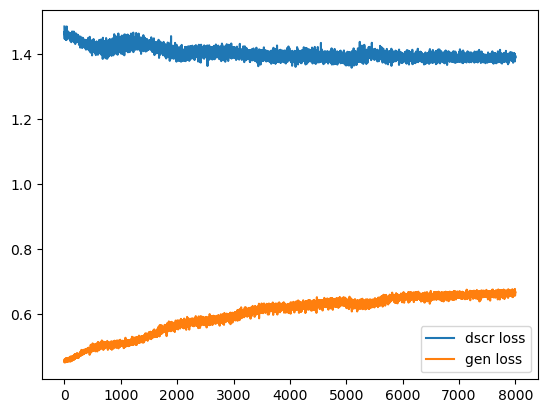

[ Info: Epoch 1: train step: 0, dscr loss: 1.5159010648749507, gen loss: 0.4564602679906399
[ Info: Epoch 6: train step: 200, dscr loss: 1.4943611541715525, gen loss: 0.45793130023720074
[ Info: Epoch 11: train step: 400, dscr loss: 1.478937695567563, gen loss: 0.4643212582347618
[ Info: Epoch 16: train step: 600, dscr loss: 1.4537123434710493, gen loss: 0.489351557035356
[ Info: Epoch 21: train step: 800, dscr loss: 1.415904977360428, gen loss: 0.5134801895142218
[ Info: Epoch 26: train step: 1000, dscr loss: 1.3841081954003593, gen loss: 0.5253064733883623
[ Info: Epoch 31: train step: 1200, dscr loss: 1.3740931162304495, gen loss: 0.5120382760183315
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4198873110208279, gen loss: 0.5202625045090205
[ Info: Epoch 41: train step: 1600, dscr loss: 1.427671162669565, gen loss: 0.5072124992879228
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4293675955070697, gen loss: 0.5216960008465815
[ Info: Epoch 51: train step: 2000, dscr loss: 1.440

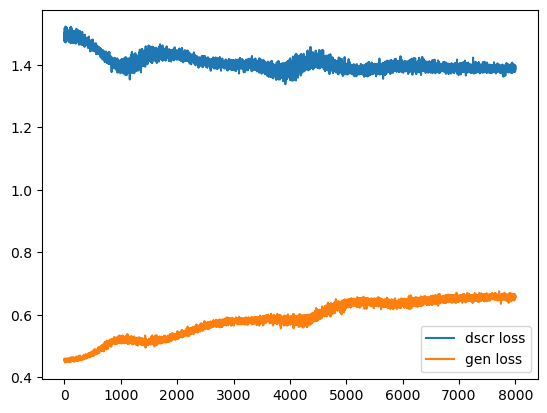

[ Info: Epoch 1: train step: 0, dscr loss: 1.4375476814997303, gen loss: 0.49304176937678135
[ Info: Epoch 6: train step: 200, dscr loss: 1.4466234739224078, gen loss: 0.4924938126803302
[ Info: Epoch 11: train step: 400, dscr loss: 1.4487541178065073, gen loss: 0.4931151706941986
[ Info: Epoch 16: train step: 600, dscr loss: 1.4489275859051747, gen loss: 0.5001990514222819
[ Info: Epoch 21: train step: 800, dscr loss: 1.4310167319042097, gen loss: 0.5055120953074337
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4297915755927189, gen loss: 0.5146648390100879
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4223562135422787, gen loss: 0.5277648003504406
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4114426638986668, gen loss: 0.5531202269036813
[ Info: Epoch 41: train step: 1600, dscr loss: 1.3926946466496761, gen loss: 0.5780873608406405
[ Info: Epoch 46: train step: 1800, dscr loss: 1.3859807495348209, gen loss: 0.5663145177014711
[ Info: Epoch 51: train step: 2000, dscr loss: 1

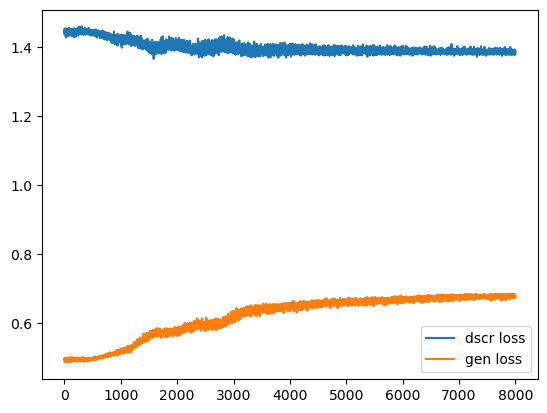

[ Info: Epoch 1: train step: 0, dscr loss: 1.4758915903677472, gen loss: 0.5007484645211799
[ Info: Epoch 6: train step: 200, dscr loss: 1.4537008342939137, gen loss: 0.504852746363397
[ Info: Epoch 11: train step: 400, dscr loss: 1.4590550789677086, gen loss: 0.5037520773084129
[ Info: Epoch 16: train step: 600, dscr loss: 1.4503732688632573, gen loss: 0.5090080162774643
[ Info: Epoch 21: train step: 800, dscr loss: 1.42887212676158, gen loss: 0.5239294598626937
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4252963834695727, gen loss: 0.5306922591940013
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4120674751196725, gen loss: 0.5319920058831763
[ Info: Epoch 36: train step: 1400, dscr loss: 1.3955938095064018, gen loss: 0.5449555672961363
[ Info: Epoch 41: train step: 1600, dscr loss: 1.3993100814319137, gen loss: 0.551186426369503
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4139338483209136, gen loss: 0.5530694293447926
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4277

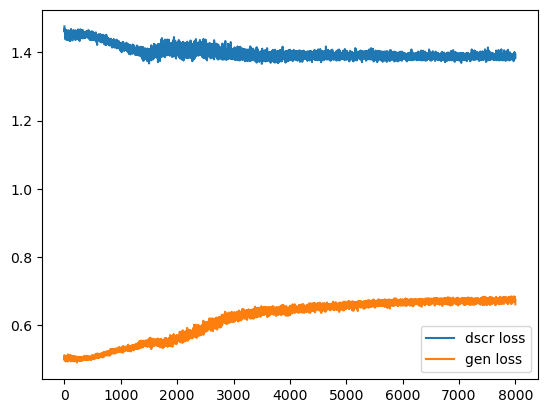

[ Info: Epoch 1: train step: 0, dscr loss: 1.4567784107194566, gen loss: 0.4803407190351568
[ Info: Epoch 6: train step: 200, dscr loss: 1.4540117733793156, gen loss: 0.48730417857757835
[ Info: Epoch 11: train step: 400, dscr loss: 1.447246082612334, gen loss: 0.498078822781978
[ Info: Epoch 16: train step: 600, dscr loss: 1.4369462457073399, gen loss: 0.4969040152820017
[ Info: Epoch 21: train step: 800, dscr loss: 1.4415604215084694, gen loss: 0.5026687678294225
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4356718294103388, gen loss: 0.5087551972729836
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4352686658332798, gen loss: 0.5236274162467066
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4164858047909257, gen loss: 0.5319982818080345
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4187787184907572, gen loss: 0.534844212667019
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4072844101069455, gen loss: 0.5479962052629036
[ Info: Epoch 51: train step: 2000, dscr loss: 1.39

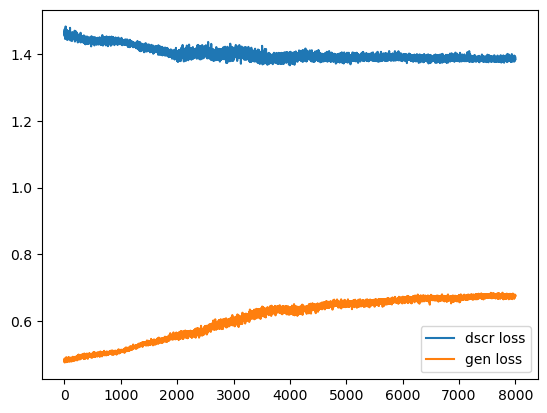

[ Info: Epoch 1: train step: 0, dscr loss: 1.4414866618632336, gen loss: 0.45928589715356155
[ Info: Epoch 6: train step: 200, dscr loss: 1.4442741668366232, gen loss: 0.4721401683924913
[ Info: Epoch 11: train step: 400, dscr loss: 1.4458819635696107, gen loss: 0.48000827843733146
[ Info: Epoch 16: train step: 600, dscr loss: 1.440890849441852, gen loss: 0.4844211749378113
[ Info: Epoch 21: train step: 800, dscr loss: 1.4303369318657344, gen loss: 0.49054601540459464
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4246687685482962, gen loss: 0.5012947596165361
[ Info: Epoch 31: train step: 1200, dscr loss: 1.434202372988209, gen loss: 0.5065840294449011
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4317411374117128, gen loss: 0.512018860450965
[ Info: Epoch 41: train step: 1600, dscr loss: 1.44072318905364, gen loss: 0.5179811273076328
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4260059725086682, gen loss: 0.5249213621900721
[ Info: Epoch 51: train step: 2000, dscr loss: 1.42

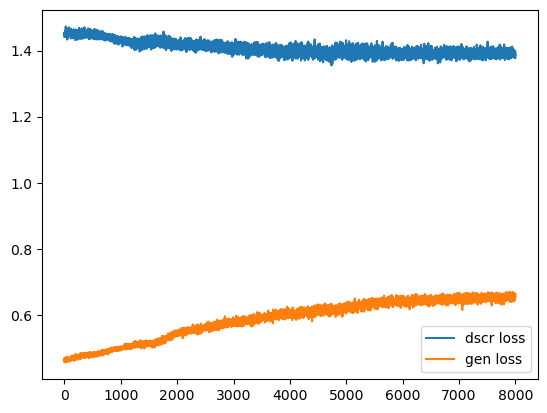

[ Info: Epoch 1: train step: 0, dscr loss: 1.449358608285107, gen loss: 0.4515665925490255
[ Info: Epoch 6: train step: 200, dscr loss: 1.4341288343593053, gen loss: 0.47536814413294176
[ Info: Epoch 11: train step: 400, dscr loss: 1.4172473438578213, gen loss: 0.48393308394451595
[ Info: Epoch 16: train step: 600, dscr loss: 1.4532542656432954, gen loss: 0.4853332706883109
[ Info: Epoch 21: train step: 800, dscr loss: 1.4268312171550295, gen loss: 0.4917806997500291
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4446953194701484, gen loss: 0.4995334783227193
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4300098941348343, gen loss: 0.5069516518180193
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4222645461968741, gen loss: 0.5283049548498477
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4112589797960458, gen loss: 0.5393337365400476
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4111429867032337, gen loss: 0.5565376185398434
[ Info: Epoch 51: train step: 2000, dscr loss: 1

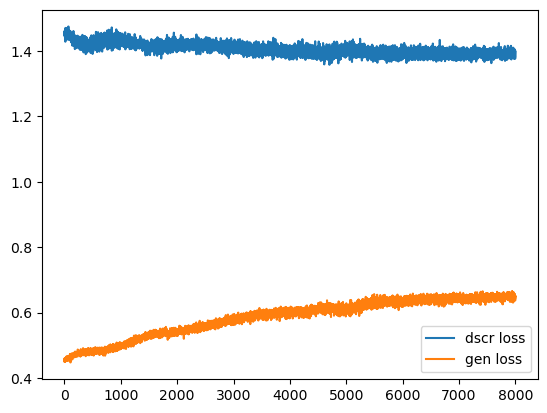

[ Info: Epoch 1: train step: 0, dscr loss: 1.451136896258377, gen loss: 0.46244421886892667
[ Info: Epoch 6: train step: 200, dscr loss: 1.4182592424515483, gen loss: 0.4841104943667145
[ Info: Epoch 11: train step: 400, dscr loss: 1.4265041119509985, gen loss: 0.5125201399543559
[ Info: Epoch 16: train step: 600, dscr loss: 1.411792219781363, gen loss: 0.5230546583042273
[ Info: Epoch 21: train step: 800, dscr loss: 1.419978845201624, gen loss: 0.5239229089523382
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4319727041874573, gen loss: 0.5302350729562713
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4444979860745164, gen loss: 0.5357519126716759
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4154030632605095, gen loss: 0.5520482302851184
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4197138341198565, gen loss: 0.5628436787183684
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4348247806948602, gen loss: 0.5837262142374335
[ Info: Epoch 51: train step: 2000, dscr loss: 1.39

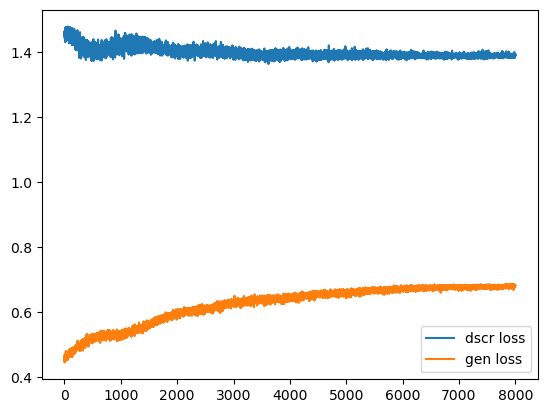

[ Info: Epoch 1: train step: 0, dscr loss: 1.4524107849956218, gen loss: 0.4713251461085802
[ Info: Epoch 6: train step: 200, dscr loss: 1.4450017561012976, gen loss: 0.4742778147025853
[ Info: Epoch 11: train step: 400, dscr loss: 1.4577807740717652, gen loss: 0.4815144977417071
[ Info: Epoch 16: train step: 600, dscr loss: 1.4441279238580864, gen loss: 0.4914854460817101
[ Info: Epoch 21: train step: 800, dscr loss: 1.4511837832104764, gen loss: 0.4887792661546001
[ Info: Epoch 26: train step: 1000, dscr loss: 1.448486971688817, gen loss: 0.49027842143809974
[ Info: Epoch 31: train step: 1200, dscr loss: 1.431665111495861, gen loss: 0.5130415445428151
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4126115650357178, gen loss: 0.527129666547607
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4262253676465164, gen loss: 0.5267913274147098
[ Info: Epoch 46: train step: 1800, dscr loss: 1.41411277272278, gen loss: 0.5529053240498489
[ Info: Epoch 51: train step: 2000, dscr loss: 1.3922

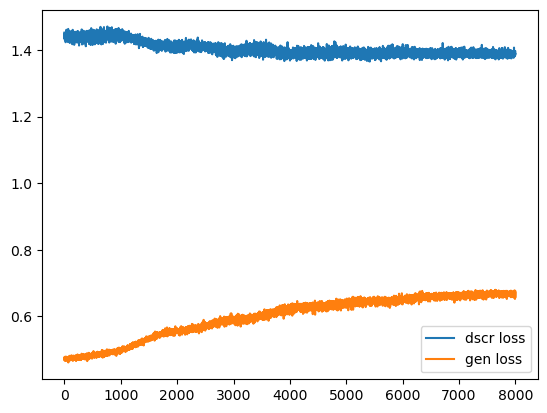

[ Info: Epoch 1: train step: 0, dscr loss: 1.4474733810509686, gen loss: 0.46196615552125037
[ Info: Epoch 6: train step: 200, dscr loss: 1.43994132359361, gen loss: 0.4824888430413101
[ Info: Epoch 11: train step: 400, dscr loss: 1.4363515654613266, gen loss: 0.48324447036154616
[ Info: Epoch 16: train step: 600, dscr loss: 1.4428665167610908, gen loss: 0.4930516033475887
[ Info: Epoch 21: train step: 800, dscr loss: 1.428538676871176, gen loss: 0.49369258970210644
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4347016631064344, gen loss: 0.5029203961506644
[ Info: Epoch 31: train step: 1200, dscr loss: 1.424354566091845, gen loss: 0.5040110506345067
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4427144882091376, gen loss: 0.5221910013114169
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4334375594157425, gen loss: 0.5157853066256236
[ Info: Epoch 46: train step: 1800, dscr loss: 1.419219044159035, gen loss: 0.516888913327578
[ Info: Epoch 51: train step: 2000, dscr loss: 1.410

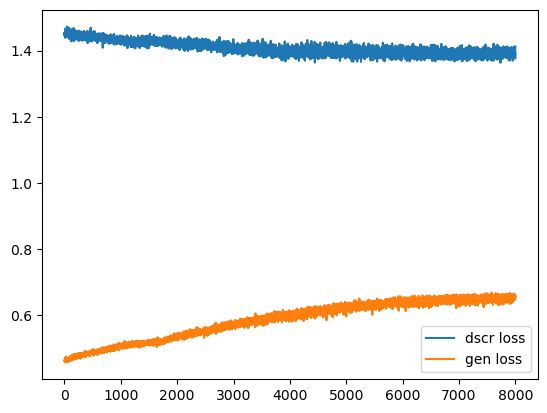

[ Info: Epoch 1: train step: 0, dscr loss: 1.4377537566995562, gen loss: 0.4708543420224107
[ Info: Epoch 6: train step: 200, dscr loss: 1.4446020948881466, gen loss: 0.4724963869680531
[ Info: Epoch 11: train step: 400, dscr loss: 1.4366059334853758, gen loss: 0.49091201142906427
[ Info: Epoch 16: train step: 600, dscr loss: 1.4352705744341867, gen loss: 0.4954408971294194
[ Info: Epoch 21: train step: 800, dscr loss: 1.4328702038216632, gen loss: 0.5092340471583467
[ Info: Epoch 26: train step: 1000, dscr loss: 1.425949009053131, gen loss: 0.5156702312963785
[ Info: Epoch 31: train step: 1200, dscr loss: 1.418083064795892, gen loss: 0.5287737405545422
[ Info: Epoch 36: train step: 1400, dscr loss: 1.415162774280347, gen loss: 0.5320721231280332
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4052407252709862, gen loss: 0.5497060281606254
[ Info: Epoch 46: train step: 1800, dscr loss: 1.396362908499436, gen loss: 0.5629849149359035
[ Info: Epoch 51: train step: 2000, dscr loss: 1.407

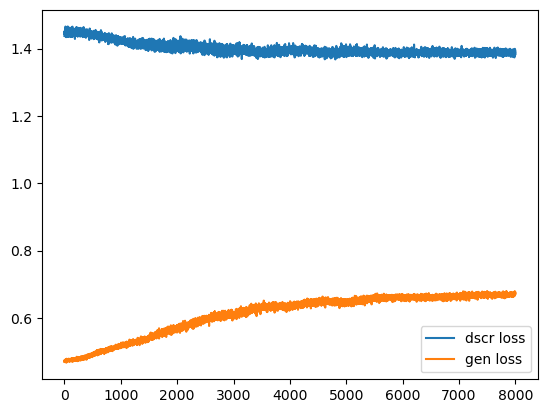

[ Info: Epoch 1: train step: 0, dscr loss: 1.461325590225198, gen loss: 0.45097544945146933
[ Info: Epoch 6: train step: 200, dscr loss: 1.456408449198853, gen loss: 0.4644245880145156
[ Info: Epoch 11: train step: 400, dscr loss: 1.4389300487703505, gen loss: 0.47255958102455636
[ Info: Epoch 16: train step: 600, dscr loss: 1.4449375308179604, gen loss: 0.48939753190897256
[ Info: Epoch 21: train step: 800, dscr loss: 1.4232998508079873, gen loss: 0.4992238516308557
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4345098527935436, gen loss: 0.5102397519074721
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4329499575578946, gen loss: 0.5151283075084973
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4271995554479013, gen loss: 0.5050283449542096
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4554549393460428, gen loss: 0.5158359097862513
[ Info: Epoch 46: train step: 1800, dscr loss: 1.450994639221225, gen loss: 0.5028522734492289
[ Info: Epoch 51: train step: 2000, dscr loss: 1.

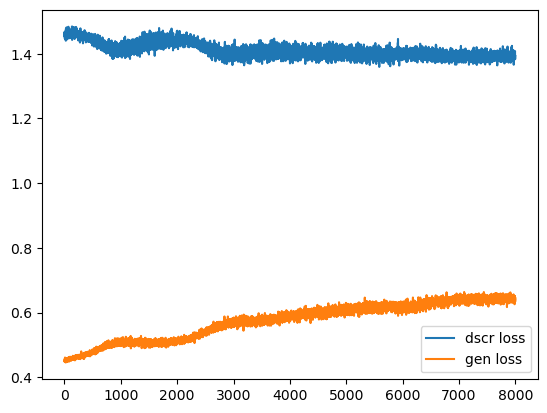

[ Info: Epoch 1: train step: 0, dscr loss: 1.4712611234544486, gen loss: 0.4407495573242356
[ Info: Epoch 6: train step: 200, dscr loss: 1.467827019525217, gen loss: 0.47006167787909314
[ Info: Epoch 11: train step: 400, dscr loss: 1.4675138197970474, gen loss: 0.49052638223623696
[ Info: Epoch 16: train step: 600, dscr loss: 1.4315563066016395, gen loss: 0.5047329725251829
[ Info: Epoch 21: train step: 800, dscr loss: 1.4126707896817918, gen loss: 0.5167519153646155
[ Info: Epoch 26: train step: 1000, dscr loss: 1.4028861791951721, gen loss: 0.5292949714525037
[ Info: Epoch 31: train step: 1200, dscr loss: 1.4167519455741524, gen loss: 0.52796409831589
[ Info: Epoch 36: train step: 1400, dscr loss: 1.4164616666784595, gen loss: 0.5201575172013743
[ Info: Epoch 41: train step: 1600, dscr loss: 1.4058988041827583, gen loss: 0.5387816121424771
[ Info: Epoch 46: train step: 1800, dscr loss: 1.4347676206670918, gen loss: 0.5506993863774603
[ Info: Epoch 51: train step: 2000, dscr loss: 1.4

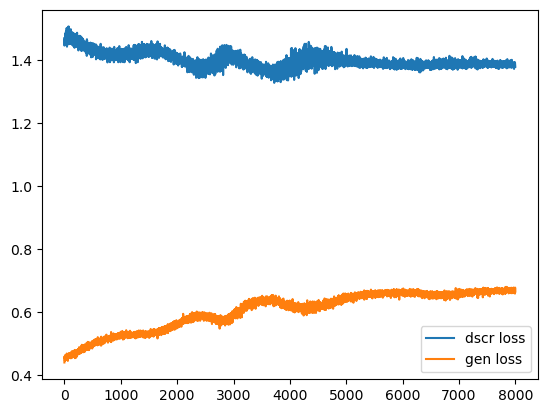

285.845244 seconds (1.15 G allocations: 351.331 GiB, 7.52% gc time)


In [512]:
hp = HyperParams()

gen_tot  = [generator(hp.latent_dim) for t in 1:TVALS]
dscr_tot = [discriminator() for t in 1:TVALS] 
@time begin
    for t in 1:TVALS
        train!(rr_re_images[t][:,:,:,:], dscr_tot[t], gen_tot[t], hp)    
    end
end


In [333]:
#all(isapprox.(dscr(rr_re_images[1][:,:,:,:]), 1, atol=0.1)) # dscr correctly classify input data as real data
dscr_tot[1](rr_re_images[1][:,:,:,:]); # dscr correctly classify input data as real data
#generate_fake_sample(gen_tot[1], hp)

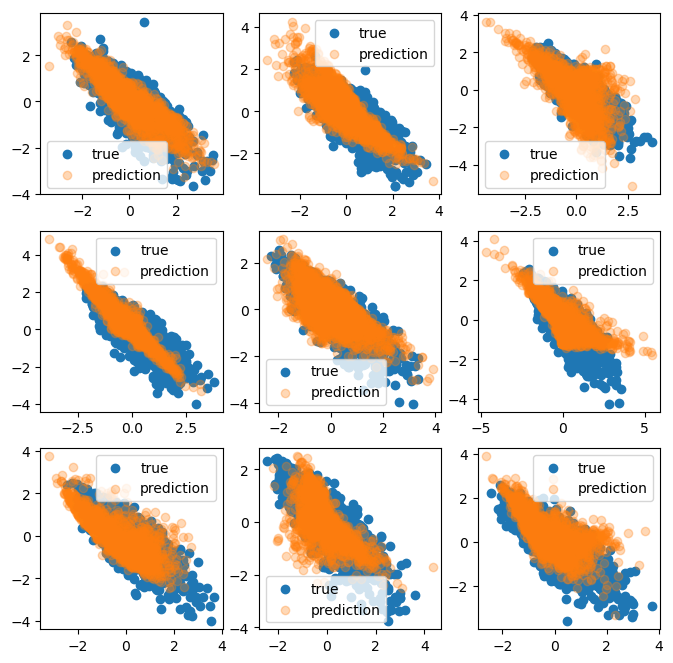

In [514]:

fig = figure(figsize=(8,8))
for k in 1:9
    
    t = k + 20
    ii = 330 + k
    fake_sample = generate_fake_sample(gen_tot[t], HyperParams(batch_size=2000))

    subplot(ii)
    scatter(rr_re_images[t][1, :, 1:1, :], rr_re_images[t][2, :, 1:1, :], label="true")
    scatter(fake_sample[1,:], fake_sample[2, :], label="prediction", alpha=0.3)
    legend()
end
#savefig(joinpath(path_plot, "GAN_prediction.pdf"))
display(gcf())
close("all")

In [472]:
fake_sample = generate_fake_sample(gen_tot[1], HyperParams(batch_size=1000))

2×1000 Matrix{Float64}:
  0.37116   -0.0125924  -0.538155   …   0.998118  0.46067    0.633914
 -0.445895   0.553902    0.0990267     -2.04001   0.763206  -0.905704

In [530]:
rr_predicted = Array{Float64}(undef, TVALS, 2000, 4)
re_predicted = Array{Float64}(undef, TVALS, 2000, 4)

for t in 1:TVALS
    for ts in 1:4
        
        fake_sample = generate_fake_sample(gen_tot[1], HyperParams(batch_size=2000))
        rr_predicted[t,:,ts] = fake_sample[1,:] .* std_val[t,ts,1] .+ mean_val[t,ts,1]        
        re_predicted[t,:,ts] = fake_sample[2,:] .* std_val[t,ts,2] .+ mean_val[t,ts,2]
    end
end

In [531]:
re_predicted;


In [532]:
corr_re_predicted = corr_obs_rr(re_predicted, "re_pred1");

tvals: 48
ncnfg: 2000
nsrcs: 4
(48, 2000)


In [533]:
corr_rr_predicted = corr_obs_rr(rr_predicted, "rr_pred1");

tvals: 48
ncnfg: 2000
nsrcs: 4
(48, 2000)


In [534]:
rr_true = permutedims(hcat(rr_re_images...)[1,:,:,:], (1,3,2)) 
re_true = permutedims(hcat(rr_re_images...)[2,:,:,:], (1,3,2)) 

for t in 1:TVALS
    for ts in 1:4
        rr_true[t,:,ts] = rr_true[t,:,ts] .* std_val[t,ts,1] .+ mean_val[t,ts,1]
        re_true[t,:,ts] = re_true[t,:,ts] .* std_val[t,ts,2] .+ mean_val[t,ts,2]
    end
end

In [535]:
re_true;

In [536]:
corr_re_true = corr_obs_rr(re_true, "re_true");

tvals: 48
ncnfg: 2000
nsrcs: 4
(48, 2000)


In [537]:
corr_rr_true = corr_obs_rr(rr_true, "rr_true");

tvals: 48
ncnfg: 2000
nsrcs: 4
(48, 2000)


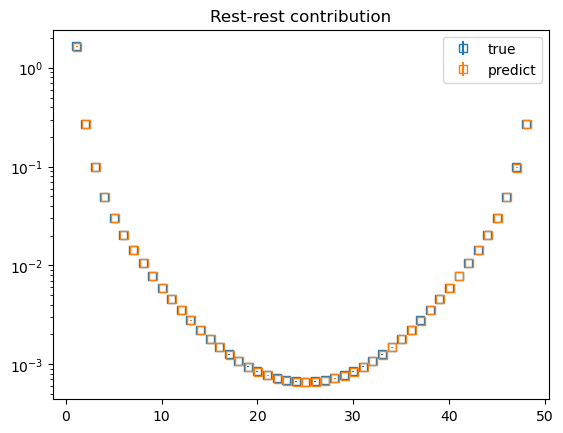

In [538]:
using ADerrors
uwerr.(corr_rr_predicted)
uwerr.(corr_rr_true)
xx = collect(1:length(corr_rr_true))
errorbar(xx, value.(corr_rr_true), err.(corr_rr_true), fmt="s", label="true", mfc="none")
errorbar(xx.+0.1, value.(corr_rr_predicted), err.(corr_rr_predicted), fmt="s", label="predict", mfc="none")
legend()
title("Rest-rest contribution")
#xlim(20,30)
#ylim(0.0004,0.001)
yscale("log")
display(gcf())
close("all")

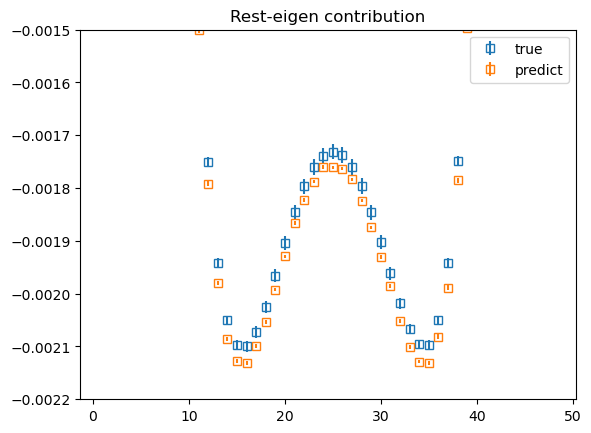

In [541]:
using ADerrors
uwerr.(corr_re_predicted)
uwerr.(corr_re_true)
xx = collect(1:length(corr_re_true))
errorbar(xx, value.(corr_re_true), err.(corr_re_true), fmt="s", label="true", mfc="none")
errorbar(xx, value.(corr_re_predicted), err.(corr_re_predicted), fmt="s", label="predict", mfc="none")
legend()
title("Rest-eigen contribution")
#xlim(5,10)
ylim(-0.0022,-0.0015)
#yscale("log")
display(gcf())
close("all")